## Importowanie pakietów

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from collections import defaultdict
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

## Definicja sieci

In [5]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim, initial_sigma=1.0, sigma_decay=1.0, init_lr=0.1, decay_rate=100, neighborhood_function='gaussian'):
        # Inicjalizacja sieci z podanymi parametrami oraz przygotowanie wag i mapy klastrów.
        self.M, self.N, self.input_dim = M, N, input_dim
        self.initial_sigma, self.sigma_decay = initial_sigma, sigma_decay
        self.init_lr, self.decay_rate = init_lr, decay_rate
        self.weights = np.random.rand(M, N, input_dim)
        self.bmu_cluster_map = np.zeros((M, N), dtype=int)
        self.neighborhood_function = neighborhood_function

    def train(self, input_data, num_epochs):
        # Proces uczenia sieci przez określoną liczbę epok.
        for epoch in range(num_epochs):
            sigma = self.initial_sigma * np.exp(-epoch / self.decay_rate) * self.sigma_decay
            learning_rate = self.init_lr * np.exp(-epoch / self.decay_rate)
            
            for data_sample in input_data:
                # Znajdź BMU i zaktualizuj wagi
                self._find_bmu_and_update_weights(data_sample, sigma, learning_rate)


    def _neighborhood_function(self, distance, sigma):
        # Funkcja sąsiedztwa, która oblicza wpływ odległości na aktualizację wag.
        if self.neighborhood_function == 'gaussian':
            return np.exp(-distance**2 / (2 * sigma**2))
        elif self.neighborhood_function == 'mexican_hat':
            return (1 - (distance**2 / sigma**2)) * np.exp(-distance**2 / (2 * sigma**2))
        else:
            raise ValueError(f"Nieznana funkcja sąsiedztwa: {self.neighborhood_function}")



    def _find_bmu_and_update_weights(self, sample, sigma, lr):
        # Znalezienie BMU, aktualizacja wag i zwrócenie BMU.
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu = np.unravel_index(np.argmin(distances), distances.shape)
        
        if sigma and lr:
            x, y = np.ogrid[0:self.M, 0:self.N]
            distance = np.sqrt((x - bmu[0])**2 + (y - bmu[1])**2)
            influence = self._neighborhood_function(distance, sigma)
            self.weights += lr * influence[..., np.newaxis] * (sample - self.weights)
        
        return bmu

    
    def assign_clusters(self, input_data):
        # Mapowanie klastrów na podstawie danych wejściowych.
        cluster_stats = defaultdict(list)

        for i, data_sample in enumerate(input_data):
            # Wyszukujemy BMU, przy czym nie aktualizujemy wag
            best_matching_unit = self._find_bmu_and_update_weights(data_sample, None, None)
            self.bmu_cluster_map[best_matching_unit] = i



    def display_clustered_data(self, input_data, neuron_positions=True, view_data=True):
        # Wizualizacja sklastrowanych danych wejściowych.
        assigned_clusters = np.array([self.bmu_cluster_map[self._find_bmu_and_update_weights(sample, None, None)] for sample in input_data])
        distinct_clusters = np.unique(assigned_clusters)
        color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d' if input_data.shape[1] == 3 else None)
        if view_data:
            # Wyświetlanie danych wejściowych sklastrowanych
            for i, cluster in enumerate(distinct_clusters):
                cluster_mask = assigned_clusters == cluster
                if input_data.shape[1] == 3:
                    ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], input_data[cluster_mask, 2], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {i}')  # Use i for cluster number
                else:
                    ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {i}')  # Use i for cluster number

        if neuron_positions:
            # Dodanie pozycji neuronów
            neuron_positions = np.array([self.weights[i, j, :] for i in range(self.M) for j in range(self.N)])
            if input_data.shape[1] == 3:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], neuron_positions[:, 2], color='red', edgecolors='k', s=100, marker='o', label='Neurony')
            else:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='red', edgecolors='k', s=100, marker='o', label='Neurony')

        ax.set_title('3D Clustered Data' if input_data.shape[1] == 3 else '2D Clustered Data')
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        if input_data.shape[1] == 3:
            ax.set_zlabel('Dim 3')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

## Załadowanie i wizualizacja danych

In [6]:
hexagon = pd.read_csv('../data/hexagon.csv').values
cube = pd.read_csv('../data/cube.csv').values

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_21670/3471852301.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_colors))


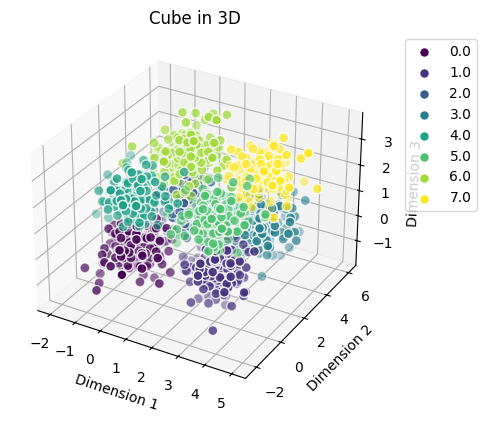

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_colors = np.unique(cube[:, 3])
colors = plt.cm.get_cmap('viridis', len(unique_colors))

for i, color in enumerate(unique_colors):
    mask = cube[:, 3] == color
    ax.scatter(cube[mask, 0], cube[mask, 1], cube[mask, 2], color=colors(i), edgecolors='w', s=50, label=f'{color}')

ax.set_title('Cube in 3D')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [8]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [9]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

## Unikalne klasy w danych

In [10]:
unique_labels = np.unique(labels_cube)
print(unique_labels)


[0. 1. 2. 3. 4. 5. 6. 7.]


## Testowanie sieci z gaussowską funkcją sąsiedztwa 

### Modyfikowanie parametrem sigma

In [11]:
network_a = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=1.0, sigma_decay=1, init_lr=0.1, decay_rate=1)

In [132]:
network_a.train(data_cube, 10)

In [133]:
network_a.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_21670/2265204966.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


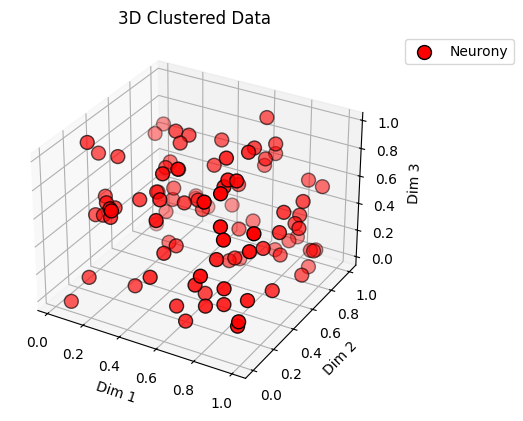

In [14]:
network_a.display_clustered_data(data_cube, view_data=False)

In [138]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [139]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [140]:
v_measure_a

0.6226170620696887

In [82]:
network_b = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.10, decay_rate=1)

In [83]:
network_b.train(data_cube, 10)

In [85]:
network_b.assign_clusters(data_cube)

In [13]:
network_b.display_clustered_data(data_cube, view_data=False)

NameError: name 'network_b' is not defined

In [141]:
predicted_labels = np.array([network_b.bmu_cluster_map[network_b._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [142]:
v_measure_b = v_measure_score(labels_cube, predicted_labels)

In [143]:
v_measure_b

0.7403283414073323

In [87]:
network_c = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.10, decay_rate=1)

In [88]:
network_c.train(data_cube, 10)

In [90]:
network_c.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


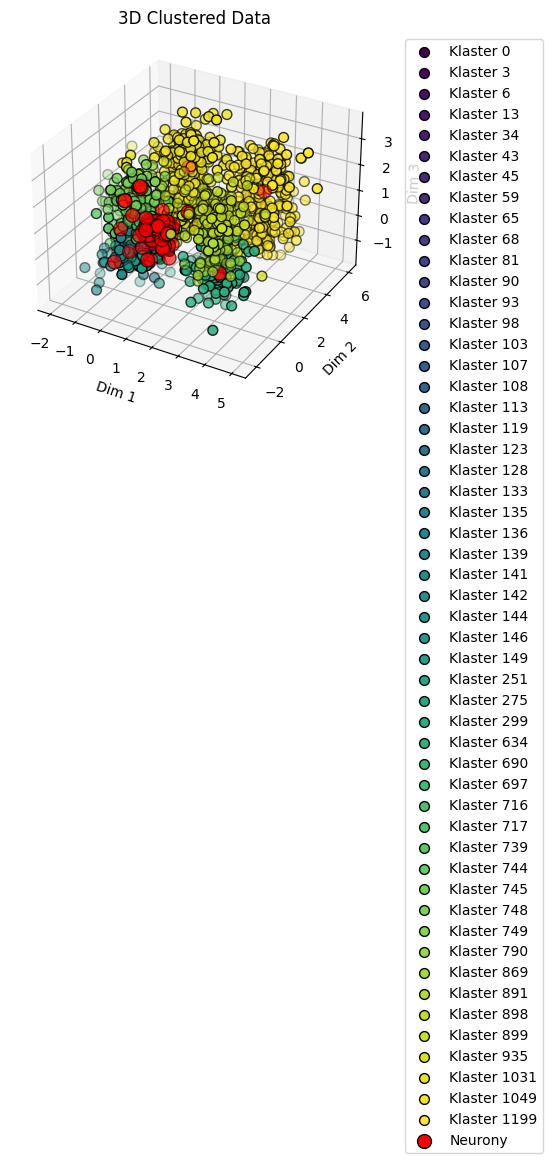

In [91]:
network_c.display_clustered_data(data_cube)

In [144]:
predicted_labels = np.array([network_c.bmu_cluster_map[network_c._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [145]:
v_measure_c = v_measure_score(labels_cube, predicted_labels)

In [146]:
v_measure_c

0.7187356964756432

### Sprawdzenie dla małego iloczynu MxN

In [153]:
network2 = KohonenNetwork(M=3, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100)


In [154]:
network2.train(data_cube,  10)

In [155]:
network2.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


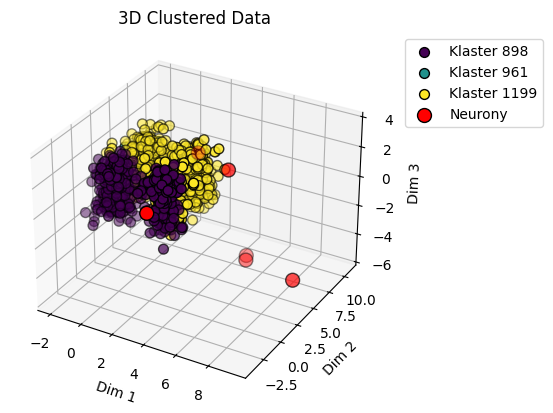

In [156]:
network2.display_clustered_data(data_cube)

In [157]:
predicted_labels = np.array([network2.bmu_cluster_map[network2._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [158]:
v_measure_2 = v_measure_score(labels_cube, predicted_labels)

In [159]:
v_measure_2

0.33453023538053256

## Testowanie sieci z funkcją sąsiedztwa minus druga pochodną funkcji gaussowskiej

### Modyfikowanie parametrem sigma

In [160]:
network_a = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=1.0, sigma_decay=1, init_lr=0.1, decay_rate=1, neighborhood_function='mexican_hat')

In [161]:
network_a.train(data_cube, 10)

In [162]:
network_a.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


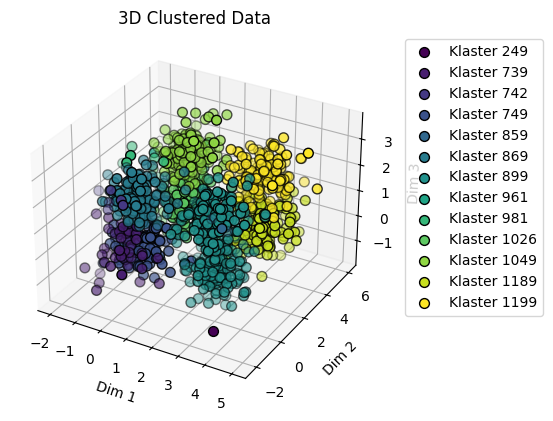

In [163]:
network_a.display_clustered_data(data_cube, neuron_positions=False)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


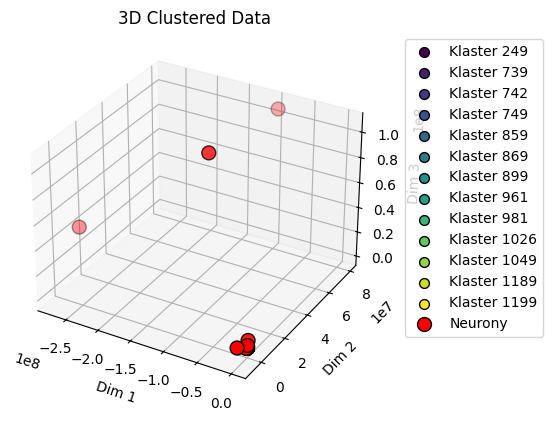

In [164]:
network_a.display_clustered_data(data_cube)

In [165]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [166]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [167]:
v_measure_a

0.8401976833542526

In [168]:
network_b = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.10, decay_rate=1, neighborhood_function='mexican_hat')

In [169]:
network_b.train(data_cube,  10)

In [170]:
network_b.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


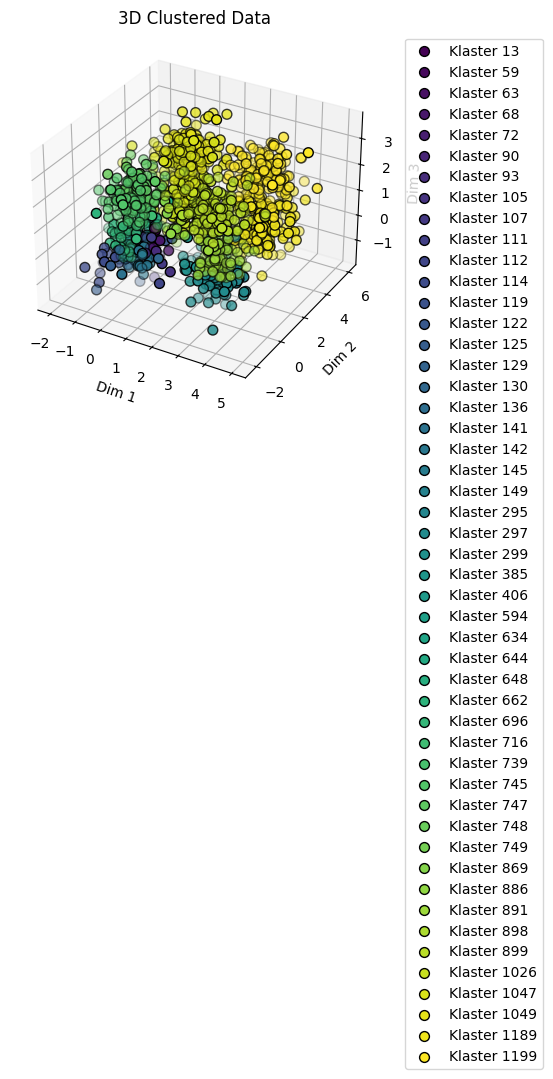

In [171]:
network_b.display_clustered_data(data_cube, neuron_positions=False)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


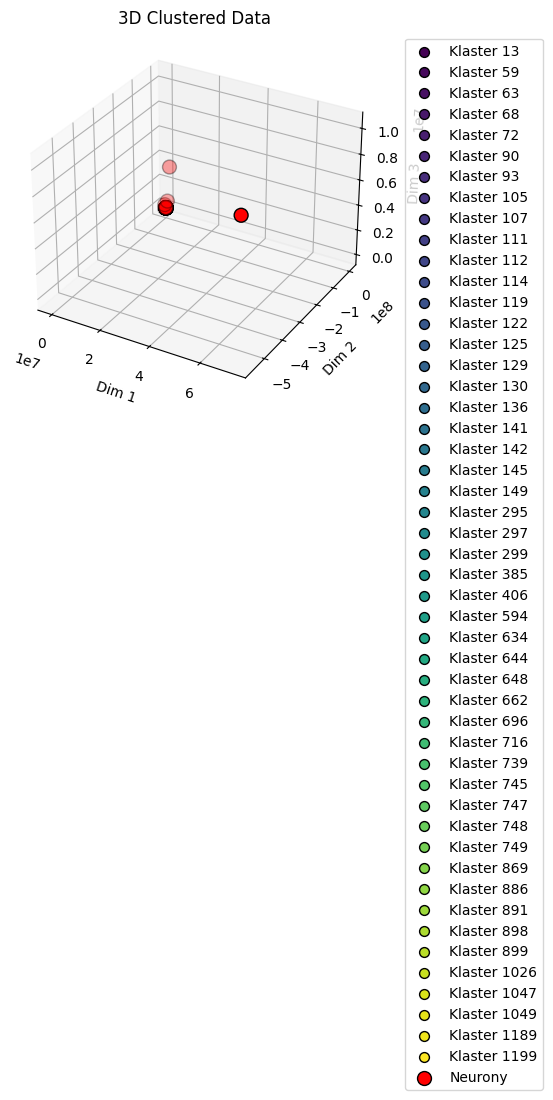

In [172]:
network_b.display_clustered_data(data_cube)

In [173]:
predicted_labels = np.array([network_b.bmu_cluster_map[network_b._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [174]:
v_measure_b = v_measure_score(labels_cube, predicted_labels)

In [175]:
v_measure_b

0.7516799398999319

In [109]:
network_c = KohonenNetwork(M=10, N=10, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.10, decay_rate=1, neighborhood_function='mexican_hat')

In [110]:
network_c.train(data_cube,  10)

In [112]:
network_c.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


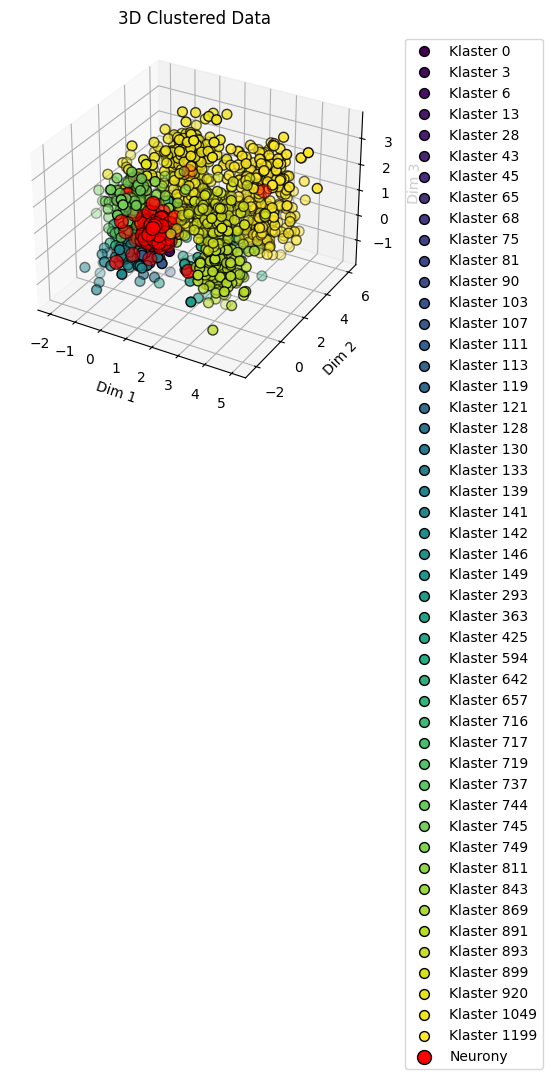

In [113]:
network_c.display_clustered_data(data_cube)

In [176]:
predicted_labels = np.array([network_c.bmu_cluster_map[network_c._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [177]:
v_measure_c = v_measure_score(labels_cube, predicted_labels)

In [178]:
v_measure_c

0.7187356964756432

### Sprawdzenie dla małego iloczynu MxN

In [114]:
network2 = KohonenNetwork(M=2, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=1, neighborhood_function='mexican_hat')


In [115]:
network2.train(data_cube, 10)

In [117]:
network2.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_71314/929895094.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


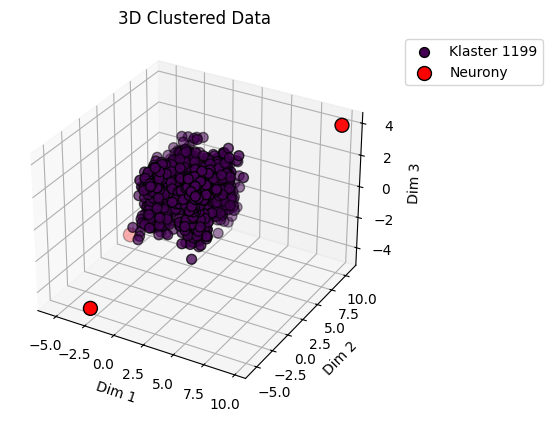

In [118]:
network2.display_clustered_data(data_cube)

In [ ]:
predicted_labels = np.array([network2.bmu_cluster_map[network2._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [ ]:
v_measure_2 = v_measure_score(labels_cube, predicted_labels)

In [ ]:
v_measure_2

0.6226170620696887